In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [2]:
from sklearn.preprocessing import StandardScaler


def read_and_filter_dataset(datasets, devices,
                            use_features=None,
                            force_columns=None,
                            use_columns=None,
                            use_activities=None,
                            scale=True,
                            with_feature_selection=False):
    # read datasets
    df, df_labels = tflscripts.read_dataset(
            datasets,
            devices,
            with_feature_selection=with_feature_selection)
    df_labels = df_labels.loc[df_labels.index.isin(df.index)]
    df = df.loc[df.index.isin(df_labels.index)]

    # filter features
    if use_features is not None:
        df, __ = tflscripts.filter_by_features(df_source=df,
                                    use_features=use_features)
        if df is None:
            return None, None

    if force_columns is not None:
        use_columns = force_columns
        tflscripts.add_empty_columns_if_missing(df, force_columns)

    # filter specific columns
    if use_columns is not None:
        try:
            df = df[use_columns]
        except KeyError as ex:
            print('No such columns found')
            return None, None

#     null_df = df.loc[df_labels.label == configuration['activities'].index('Null')]
#     null_mean = null_df[null_df.columns].mean()
#     null_std = null_df[null_df.columns].std()

    # filter activities
    if use_activities is not None:
        df, df_labels = tflscripts.filter_by_activities(df, df_labels, use_activities)
        if df is None:
            print('Activities not found')
            return None, None
    # sort feature columns
    df = tflscripts.X_sort(df)

    # scale domains
    if scale:
        df[df.columns] = StandardScaler().fit_transform(df[df.columns])
#         df[df.columns] = (df[df.columns] - null_mean) / null_std
#         df = df.replace([np.inf, -np.inf], np.nan)
    return df, df_labels


In [20]:
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
    "Kettle",
    "Chopping food",
    "Conversation",
    "Eating popcorn",
    "Knocking",
    "Phone vibrating"
]

tests = [
    ['synergy-final-iter1', '128.237.254.195', 'synergy-final-iter2', '128.237.248.186'],
    ['synergy-final-iter1', '128.237.254.195', 'synergy-final-iter1', '128.237.246.127'],
    ['scott-final-iter1', '128.237.247.134', 'synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134', 'scott-final-iter1', '128.237.248.186'],
    ['robotics-final', '128.237.246.127', 'scott-final-iter1', '128.237.247.134'],
    ['robotics-final', '128.237.246.127', 'robotics-final', '128.237.247.134'],
]

test_labels = [
    'Synergy, sink, replica',
    'Synergy (sink) to Synergy (coffee)',
    'Scott (right) to Synergy (sink)',
    'Scott (right) to Scott (left)',
    'Robotics (coffee) to Scott (right)',
    'Robotics (coffee) to Robotics (sink)',
]


configuration = tflscripts.read_configuration()
activities_i = [configuration['activities'].index(a) for a in activities]


use_features = ".*"

In [26]:
results = []
accuracies = []

for n, test in enumerate(tests):
    source_dataset = test[0]
    source_device = test[1]
    target_dataset = test[2]
    target_device = test[3]

    df_source, df_source_labels = read_and_filter_dataset(
            source_dataset + '-2s',
            source_device,
            use_features=use_features,
            use_activities=activities_i,
            scale=True,
            with_feature_selection=False)

    df_target, df_target_labels = read_and_filter_dataset(
            target_dataset + '-2s',
            target_device,
            use_features=use_features,
            use_activities=activities_i,
            scale=True,
            with_feature_selection=False)

    if len(df_source.columns) != len(df_target.columns):
        continue

    ppl = Pipeline([
        ('impute', Imputer()),
        ('clf', svm.SVC(kernel='linear', decision_function_shape='ovr'))
    ])

    ppl.fit(df_source, df_source_labels['label'])

    predicted = ppl.predict(df_target)
    y_test = df_target_labels['label'].values

    accuracy = accuracy_score(y_test, predicted)
    accuracies.append([n, accuracy])

    for i in np.unique(y_test):
        activity = configuration['activities'][int(i)]
        correct = len([x for x in predicted[y_test == i] if x == i])
        incorrect = len([x for x in predicted[y_test == i] if x != i])
        results.append([n, activity, correct, incorrect])

In [27]:
results_df = pd.DataFrame(results)
results_df.columns = ['test', 'activity', 'correct', 'incorrect']
results_df = results_df.sort_values('activity')
results_df['accuracy'] = results_df['correct'] / (results_df['correct'] + results_df['incorrect'])
results_df['test_label'] = [test_labels[int(i)] for i in results_df['test']]

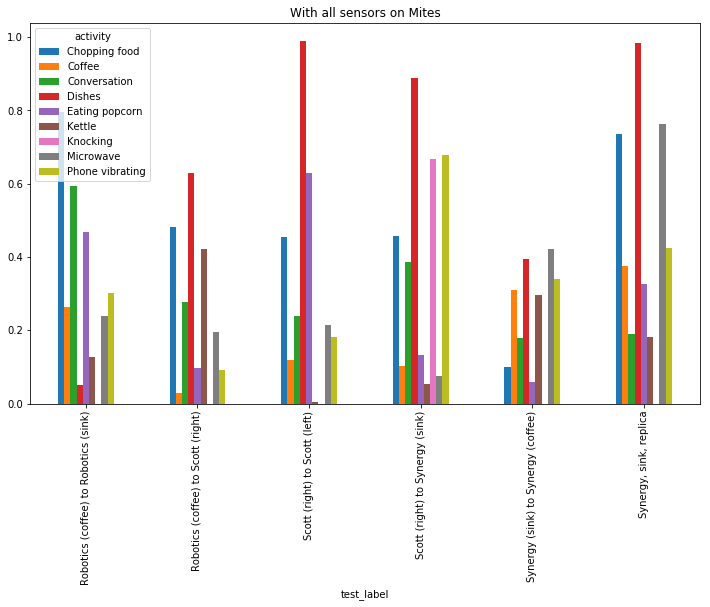

In [28]:
results_df['accuracy'] = results_df['correct'] / (results_df['correct'] + results_df['incorrect'])
grouped_results = pd.DataFrame(results_df.groupby(['activity', 'test_label'])['accuracy'].mean())
grouped_results = grouped_results.reset_index()
grouped_results = grouped_results.pivot(index='test_label', columns='activity', values='accuracy')
grouped_results.plot.bar()
plt.title('With all sensors on Mites')